In [106]:
# Configuration - Edit these values
OBJECT_NAME = "Cocoon"  # The object to calibrate
SPECIFIC_DATE = None    # Set to a date string like "2024-01-15" or None to list available dates

In [107]:
# Import required libraries
import sys
sys.path.insert(0, 'src')

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astrofiler.models import fitsFile, fitsSession, Masters
from datetime import datetime

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 10)
%matplotlib inline

## Find Light Frames for Object

Query the database to find light frames for the specified object.

In [108]:
# Search for light frames matching the object
print(f"Searching for '{OBJECT_NAME}' light frames...")
object_lights = fitsFile.select().where(
    (fitsFile.fitsFileObject == OBJECT_NAME) & 
    (fitsFile.fitsFileType.contains('LIGHT') | fitsFile.fitsFileType.contains('light') | fitsFile.fitsFileType.contains('Light'))
)
print(f"Found {object_lights.count()} light frames for {OBJECT_NAME}")

if object_lights.count() == 0:
        raise ValueError(f"No light frames found for '{OBJECT_NAME}'. Please check the object name.")

Searching for 'Cocoon' light frames...
Found 10 light frames for Cocoon


## Select Date (if multiple sessions exist)

If no specific date was provided, list available dates and use the first one.

In [109]:
# Group light frames by date
dates_dict = {}
for light in object_lights:
    if light.fitsFileDate:
        date_str = light.fitsFileDate.split('T')[0]  # Extract date part (YYYY-MM-DD)
        if date_str not in dates_dict:
            dates_dict[date_str] = []
        dates_dict[date_str].append(light)

available_dates = sorted(dates_dict.keys())
print(f"\nAvailable observation dates for {OBJECT_NAME}:")
for i, date in enumerate(available_dates, 1):
    print(f"  {i}. {date} ({len(dates_dict[date])} frames)")

# Select date
if SPECIFIC_DATE:
    if SPECIFIC_DATE not in available_dates:
        raise ValueError(f"Date '{SPECIFIC_DATE}' not found. Available dates: {available_dates}")
    selected_date = SPECIFIC_DATE
    print(f"\nUsing specified date: {selected_date}")
else:
    selected_date = available_dates[0]
    print(f"\nNo date specified, using first available: {selected_date}")
    print(f"To use a different date, set SPECIFIC_DATE = '{selected_date}' in the first cell")

# Filter lights for selected date
selected_lights = dates_dict[selected_date]
print(f"\nFound {len(selected_lights)} light frames for {OBJECT_NAME} on {selected_date}")


Available observation dates for Cocoon:
  1. 2024-10-24 (10 frames)

No date specified, using first available: 2024-10-24
To use a different date, set SPECIFIC_DATE = '2024-10-24' in the first cell

Found 10 light frames for Cocoon on 2024-10-24


## Load First Light Frame

Load the first light frame and display its properties.

Using light frame: K:/00 REPOSITORY/Light/Cocoon/ES_AR102/ZWO_CCD_ASI294MC/20241024/Cocoon-ES_AR102-ZWO_CCD_ASI294MC-OSC-20241024001322-30.0s-1x1-t16.9.fits
Session: e5c453b6-674a-4a6c-863f-1216030a38cc

Light Frame Properties:
  Shape: (2822, 4144)
  Binning: 1x1
  Camera: ZWO CCD ASI294MC
  Telescope: ES AR102
  Exposure: 30.0s
  Filter: RGB

Light Frame Properties:
  Shape: (2822, 4144)
  Binning: 1x1
  Camera: ZWO CCD ASI294MC
  Telescope: ES AR102
  Exposure: 30.0s
  Filter: RGB


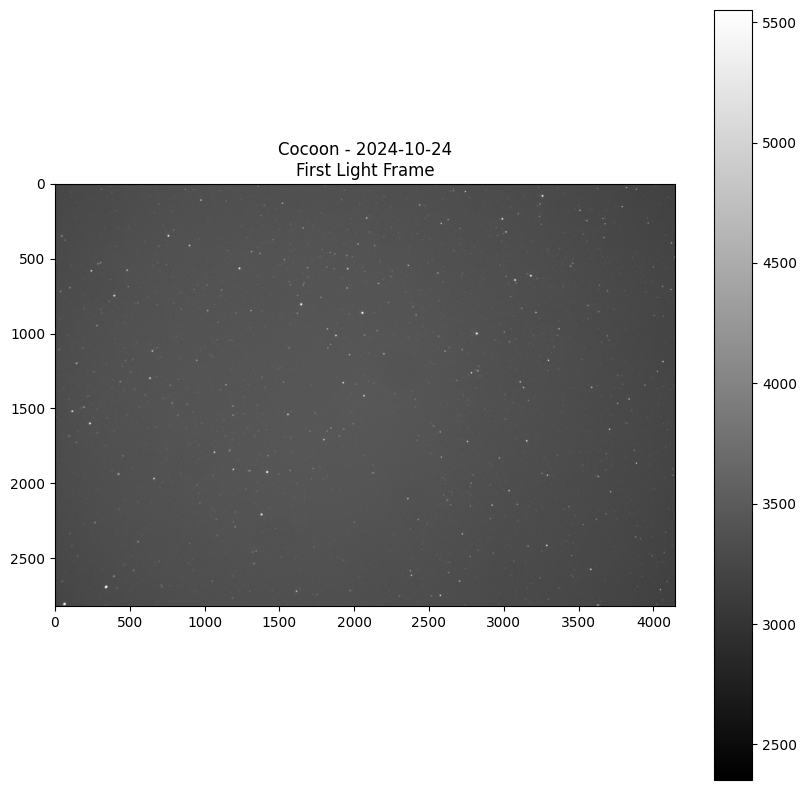

In [110]:
# Get first light frame
first_light = selected_lights[0]
print(f"Using light frame: {first_light.fitsFileName}")
print(f"Session: {first_light.fitsFileSession}")

# Load the data and header
with fits.open(first_light.fitsFileName) as hdul:
    light_data = hdul[0].data.astype(np.float64)
    light_header = hdul[0].header

print(f"\nLight Frame Properties:")
print(f"  Shape: {light_data.shape}")
print(f"  Binning: {light_header.get('XBINNING', 1)}x{light_header.get('YBINNING', 1)}")
print(f"  Camera: {light_header.get('INSTRUME', 'Unknown')}")
print(f"  Telescope: {light_header.get('TELESCOP', 'Unknown')}")
print(f"  Exposure: {light_header.get('EXPTIME', 'N/A')}s")
print(f"  Filter: {light_header.get('FILTER', 'Unknown')}")

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(light_data, cmap='gray', vmin=np.percentile(light_data, 5), vmax=np.percentile(light_data, 99))
plt.colorbar()
plt.title(f'{OBJECT_NAME} - {selected_date}\nFirst Light Frame')
plt.show()

## Find Matching Calibration Masters

Find the bias, dark, and flat masters that match this light frame's characteristics.

In [111]:
# Extract light frame characteristics for matching
light_binning_x = str(light_header.get('XBINNING', 1))
light_binning_y = str(light_header.get('YBINNING', 1))
light_camera = light_header.get('INSTRUME', '')
light_filter = light_header.get('FILTER', '')

print(f"Searching for masters matching:")
print(f"  Binning: {light_binning_x}x{light_binning_y}")
print(f"  Camera: {light_camera}")
print(f"  Filter: {light_filter} (for flat only)")

# Find matching bias master
bias_master = (Masters.select()
               .where(
                   (Masters.master_type == 'bias') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching dark master
dark_master = (Masters.select()
               .where(
                   (Masters.master_type == 'dark') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching flat master (should match filter too) - FIXED: use filter_name instead of filter
flat_master = (Masters.select()
               .where(
                   (Masters.master_type == 'flat') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera) &
                   (Masters.filter_name == light_filter)
               )
               .order_by(Masters.creation_date.desc())
               .first())

print(f"\n{'='*60}")
# Add session number for master not found cases

print(f"Bias Master: {bias_master.master_path if bias_master else '❌ Not found for session ' + str(first_light.fitsFileSession)}")
if bias_master:
    print(f"  Binning: {bias_master.binning_x}x{bias_master.binning_y}")
    print(f"  Created: {bias_master.creation_date}")
    
print(f"\nDark Master: {dark_master.master_path if dark_master else '❌ Not found for session ' + str(first_light.fitsFileSession)}")
if dark_master:
    print(f"  Binning: {dark_master.binning_x}x{dark_master.binning_y}")
    print(f"  Created: {dark_master.creation_date}")
    
print(f"\nFlat Master: {flat_master.master_path if flat_master else '❌ Not found for session ' + str(first_light.fitsFileSession)}")
if flat_master:
    print(f"  Binning: {flat_master.binning_x}x{flat_master.binning_y}")
    print(f"  Filter: {flat_master.filter_name}")
    print(f"  Created: {flat_master.creation_date}")
print(f"{'='*60}")

Searching for masters matching:
  Binning: 1x1
  Camera: ZWO CCD ASI294MC
  Filter: RGB (for flat only)

Bias Master: K:/00 REPOSITORY/Masters\Master-Bias-Explore_Scientific_FL-AR102600TN_600_F_5.9-ZWO_CCD_ASI294MC-20240530-3.2e-05s-1x1-t22.8.fits
  Binning: 1x1
  Created: 2025-11-15 14:21:23.773128

Dark Master: K:/00 REPOSITORY/Masters\Master-Dark-EQMod_Mount-ZWO_CCD_ASI294MC-20221019-30.0s-1x1-t4.9.fits
  Binning: 1x1
  Created: 2025-12-13 11:56:45.986303

Flat Master: K:/00 REPOSITORY/Masters\Master-Flat-Explore_Scientific_FL-AR102600TN_600_F_5.9-ZWO_CCD_ASI294MC-RGB-20240530-0.1463494s-1x1-t24.6.fits
  Binning: 1x1
  Filter: RGB
  Created: 2025-11-15 12:23:28.804188


## Load Calibration Frames

Load all calibration frames and verify dimensions match.

In [112]:
# Load bias
if bias_master:
    with fits.open(bias_master.master_path) as hdul:
        bias_data = hdul[0].data.astype(np.float64)
        
    print(f"Bias Frame Shape: {bias_data.shape}")
    print(f"  Min: {np.min(bias_data):.1f}, Max: {np.max(bias_data):.1f}")
    print(f"  Mean: {np.mean(bias_data):.1f}, Median: {np.median(bias_data):.1f}")
    
    if bias_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Bias shape {bias_data.shape} doesn't match light {light_data.shape}")
else:
    print("⚠️ No bias master found!")
    bias_data = None

# Load dark
if dark_master:
    with fits.open(dark_master.master_path) as hdul:
        dark_data = hdul[0].data.astype(np.float64)
        dark_header = hdul[0].header
        
    print(f"\nDark Frame Shape: {dark_data.shape}")
    print(f"  Min: {np.min(dark_data):.1f}, Max: {np.max(dark_data):.1f}")
    print(f"  Mean: {np.mean(dark_data):.1f}, Median: {np.median(dark_data):.1f}")
    print(f"  Exposure: {dark_header.get('EXPTIME', 'N/A')}s")
    
    if dark_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Dark shape {dark_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No dark master found!")
    dark_data = None

# Load flat
if flat_master:
    with fits.open(flat_master.master_path) as hdul:
        flat_data = hdul[0].data.astype(np.float64)
        
    print(f"\nFlat Frame Shape: {flat_data.shape}")
    print(f"  Min: {np.min(flat_data):.1f}, Max: {np.max(flat_data):.1f}")
    print(f"  Mean: {np.mean(flat_data):.1f}, Median: {np.median(flat_data):.1f}")
    
    if flat_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Flat shape {flat_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No flat master found!")
    flat_data = None

# Validation summary
print(f"\n{'='*60}")
if all([bias_data is not None, dark_data is not None, flat_data is not None]):
    if all([bias_data.shape == light_data.shape, 
            dark_data.shape == light_data.shape,
            flat_data.shape == light_data.shape]):
        print("✅ All calibration frames loaded and dimensions match!")
    else:
        print("❌ Dimension mismatch detected - calibration will fail!")
else:
    print("❌ Some calibration frames are missing!")
print(f"{'='*60}")

Bias Frame Shape: (2822, 4144)
  Min: 2005.0, Max: 4549.0
  Mean: 2537.8, Median: 2126.0

Dark Frame Shape: (2822, 4144)
  Min: 1925.0, Max: 65535.0
  Mean: 2535.5, Median: 2118.0
  Exposure: 30.0s
  Mean: 2535.5, Median: 2118.0
  Exposure: 30.0s

Flat Frame Shape: (2822, 4144)
  Min: 10547.0, Max: 56355.0
  Mean: 31565.0, Median: 32113.0

✅ All calibration frames loaded and dimensions match!

Flat Frame Shape: (2822, 4144)
  Min: 10547.0, Max: 56355.0
  Mean: 31565.0, Median: 32113.0

✅ All calibration frames loaded and dimensions match!


## Visualize Raw Frames

Display the raw light frame and all calibration frames.

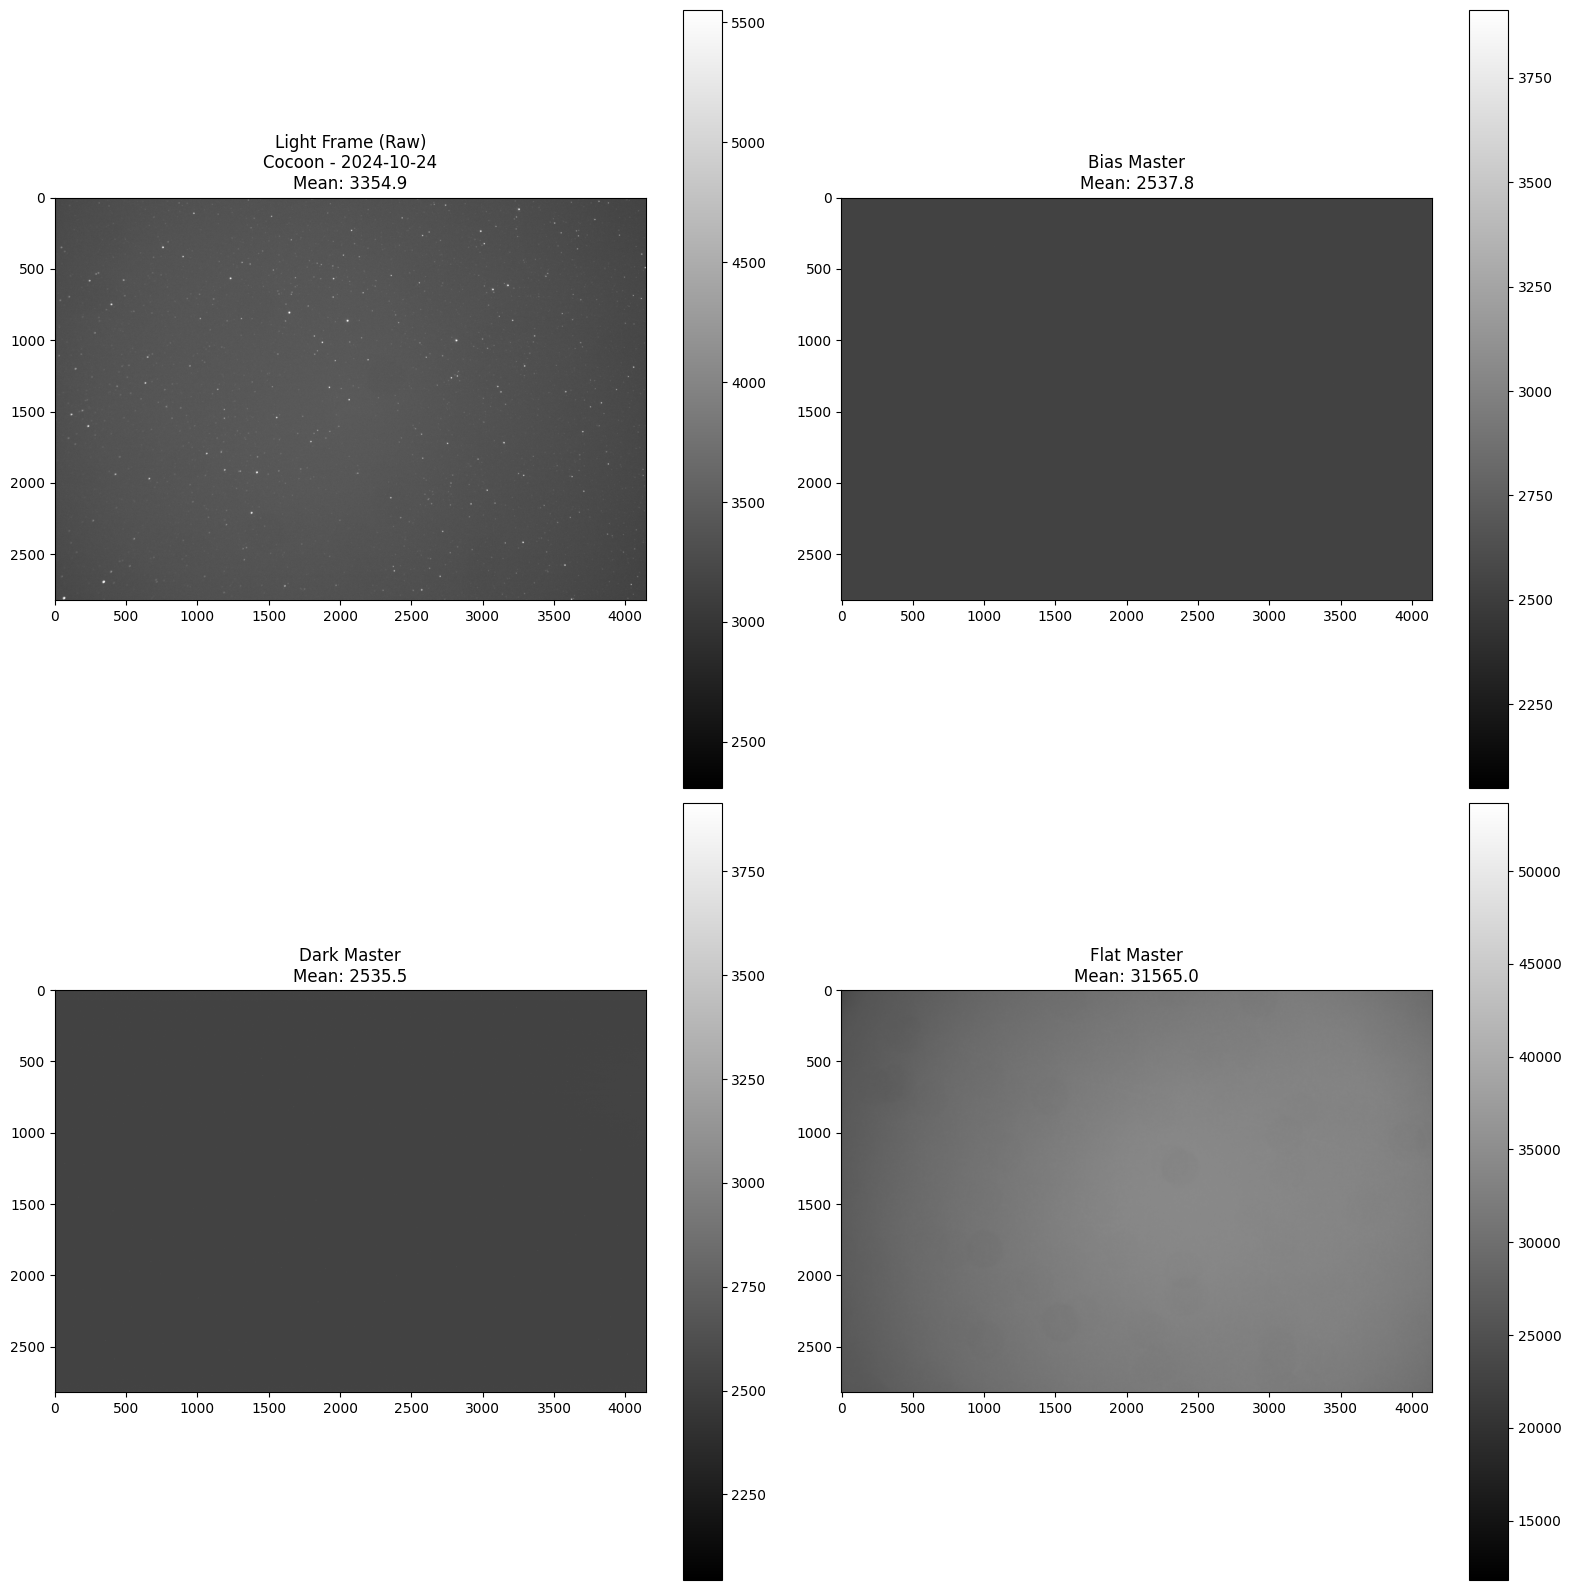

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot light frame
im0 = axes[0, 0].imshow(light_data, cmap='gray', vmin=np.percentile(light_data, 1), 
                         vmax=np.percentile(light_data, 99))
axes[0, 0].set_title(f'Light Frame (Raw)\n{OBJECT_NAME} - {selected_date}\nMean: {np.mean(light_data):.1f}')
plt.colorbar(im0, ax=axes[0, 0])

# Plot bias
if bias_data is not None:
    im1 = axes[0, 1].imshow(bias_data, cmap='gray', vmin=np.percentile(bias_data, 1), 
                             vmax=np.percentile(bias_data, 99))
    axes[0, 1].set_title(f'Bias Master\nMean: {np.mean(bias_data):.1f}')
    plt.colorbar(im1, ax=axes[0, 1])
else:
    axes[0, 1].text(0.5, 0.5, 'No Bias Master', ha='center', va='center', fontsize=20)
    axes[0, 1].set_title('Bias Master - Not Found')

# Plot dark
if dark_data is not None:
    im2 = axes[1, 0].imshow(dark_data, cmap='gray', vmin=np.percentile(dark_data, 1), 
                             vmax=np.percentile(dark_data, 99))
    axes[1, 0].set_title(f'Dark Master\nMean: {np.mean(dark_data):.1f}')
    plt.colorbar(im2, ax=axes[1, 0])
else:
    axes[1, 0].text(0.5, 0.5, 'No Dark Master', ha='center', va='center', fontsize=20)
    axes[1, 0].set_title('Dark Master - Not Found')

# Plot flat
if flat_data is not None:
    im3 = axes[1, 1].imshow(flat_data, cmap='gray', vmin=np.percentile(flat_data, 1), 
                             vmax=np.percentile(flat_data, 99))
    axes[1, 1].set_title(f'Flat Master\nMean: {np.mean(flat_data):.1f}')
    plt.colorbar(im3, ax=axes[1, 1])
else:
    axes[1, 1].text(0.5, 0.5, 'No Flat Master', ha='center', va='center', fontsize=20)
    axes[1, 1].set_title('Flat Master - Not Found')

plt.tight_layout()
plt.show()

## Perform Step-by-Step Calibration

Execute calibration step by step and examine what happens at each stage.

In [114]:
if dark_data is None or flat_data is None:
    print("❌ Cannot perform calibration - missing required calibration frames!")
    print("Please ensure dark and flat masters exist for this configuration.")
else:
    # Step 1: Subtract Dark (which includes bias)
    step1 = light_data - dark_data
    
    print("Step 1: Dark Subtraction")
    print(f"  Min: {np.min(step1):.1f}, Max: {np.max(step1):.1f}")
    print(f"  Mean: {np.mean(step1):.1f}, Median: {np.median(step1):.1f}")
    print(f"  5th percentile (background): {np.percentile(step1, 5):.1f}")
    print(f"  95th percentile (bright): {np.percentile(step1, 95):.1f}")
    
    # Step 2: Normalize flat
    flat_median = np.median(flat_data)
    flat_normalized = flat_data / flat_median
    print(f"\nStep 2: Flat Normalization")
    print(f"  Flat median: {flat_median:.1f}")
    print(f"  Normalized flat range: [{np.min(flat_normalized):.3f}, {np.max(flat_normalized):.3f}]")
    
    # Step 3: Divide by flat
    step2 = step1 / flat_normalized
    
    print(f"\nStep 3: Flat Division")
    print(f"  Min: {np.min(step2):.1f}, Max: {np.max(step2):.1f}")
    print(f"  Mean: {np.mean(step2):.1f}, Median: {np.median(step2):.1f}")
    print(f"  5th percentile (background): {np.percentile(step2, 5):.1f}")
    print(f"  95th percentile (bright): {np.percentile(step2, 95):.1f}")
    
    calibrated = step2
    print(f"\n✅ Calibration complete!")

Step 1: Dark Subtraction
  Min: -3267.0, Max: 63485.0
  Mean: 819.3, Median: 814.0
  5th percentile (background): 220.0
  95th percentile (bright): 1513.0

Step 2: Flat Normalization
  Flat median: 32113.0
  Normalized flat range: [0.328, 1.755]
  5th percentile (background): 220.0
  95th percentile (bright): 1513.0

Step 2: Flat Normalization
  Flat median: 32113.0
  Normalized flat range: [0.328, 1.755]

Step 3: Flat Division
  Min: -3135.5, Max: 147555.0
  Mean: 797.9, Median: 808.2

Step 3: Flat Division
  Min: -3135.5, Max: 147555.0
  Mean: 797.9, Median: 808.2
  5th percentile (background): 513.7
  95th percentile (bright): 1024.0

✅ Calibration complete!
  5th percentile (background): 513.7
  95th percentile (bright): 1024.0

✅ Calibration complete!


## Compare Original vs Calibrated

Visualize the calibration process results.

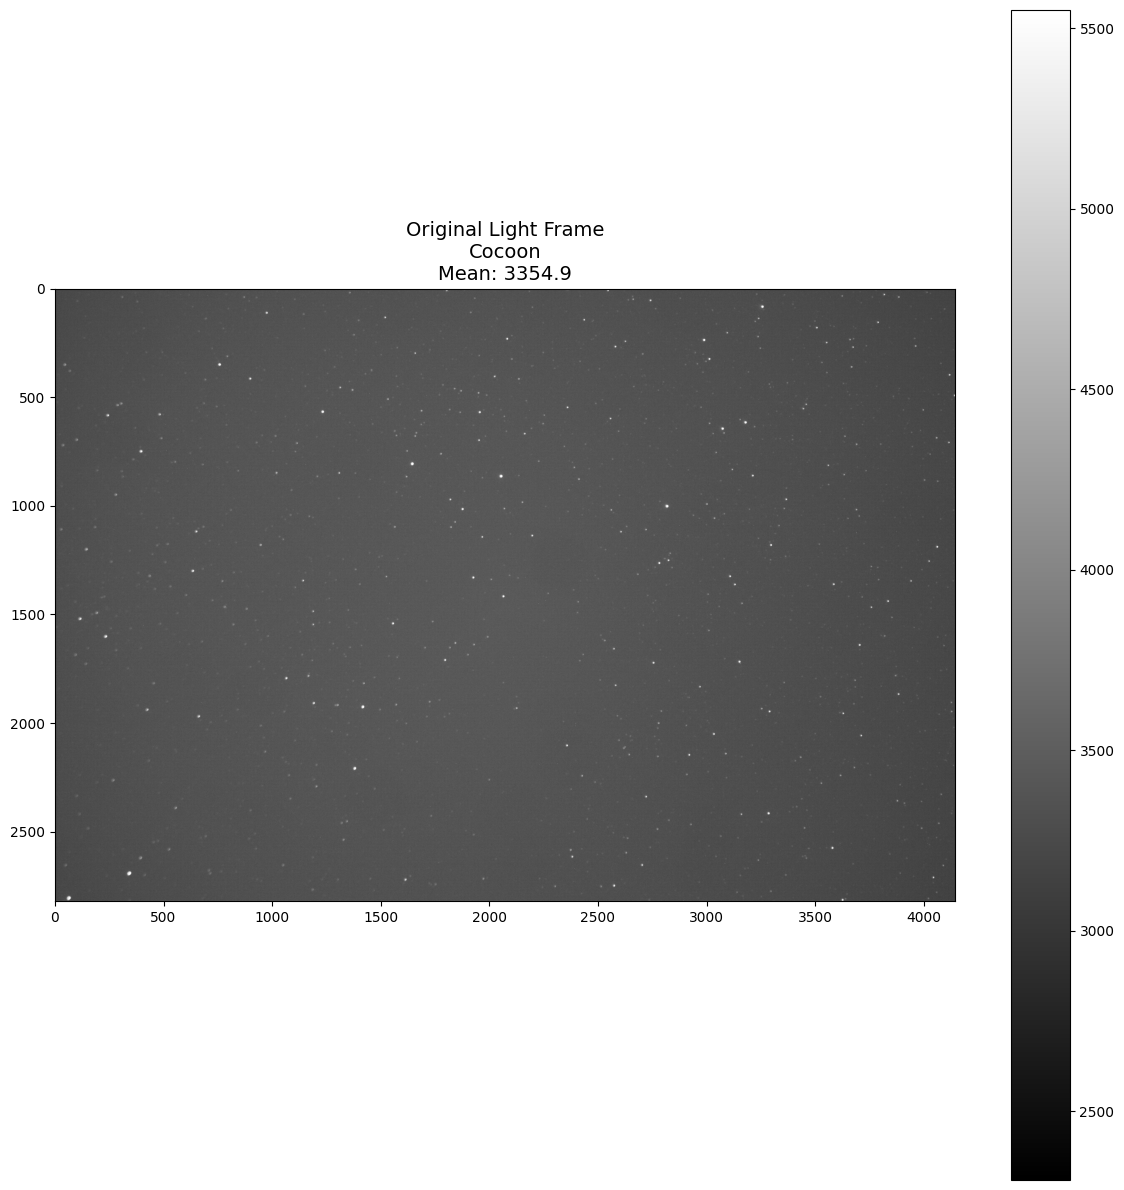

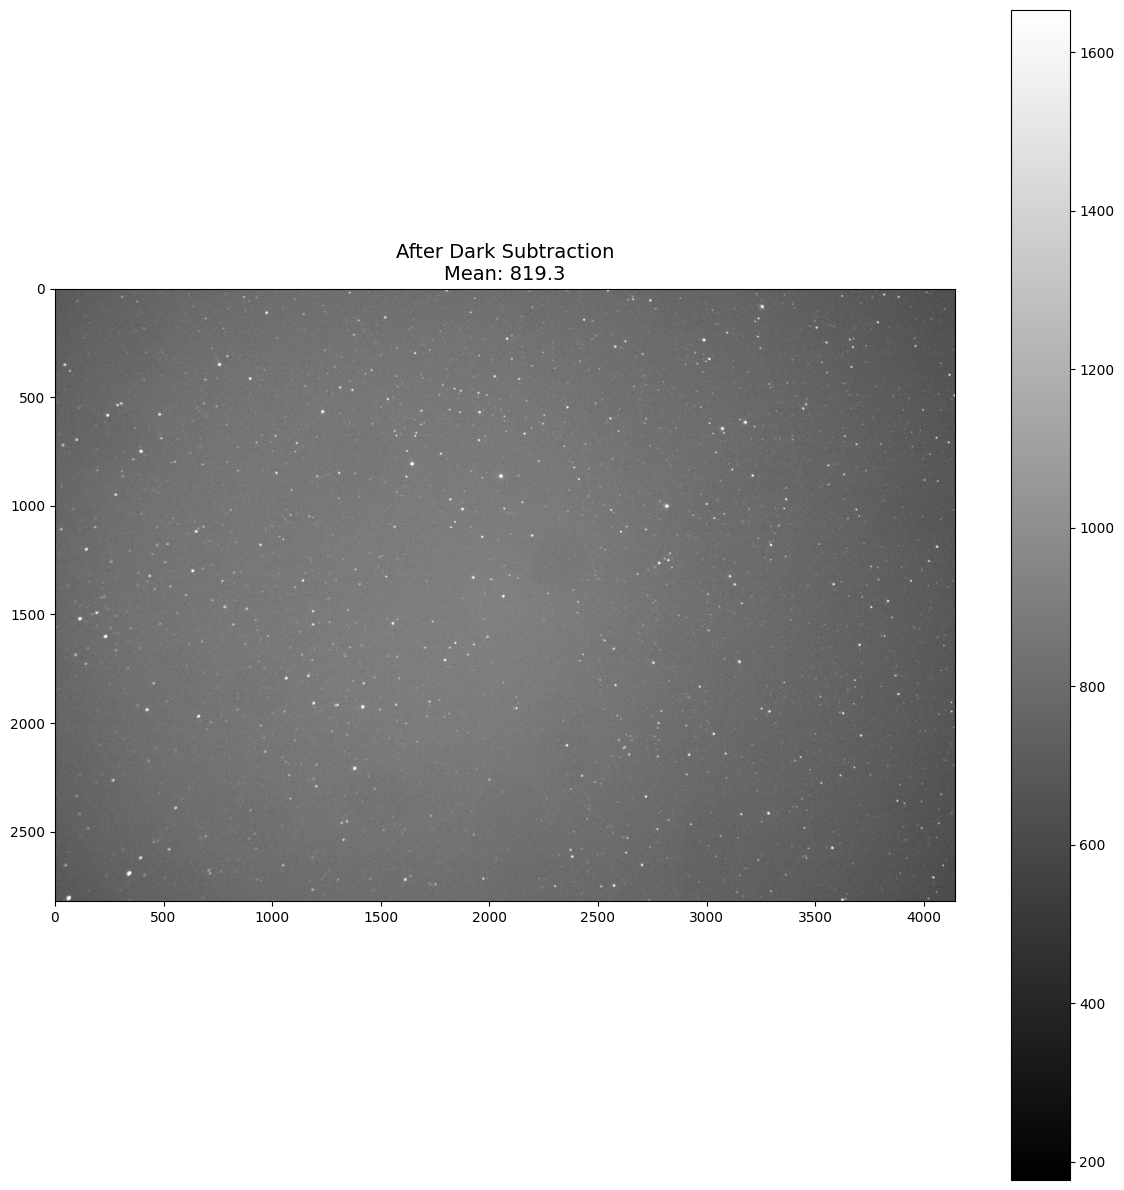

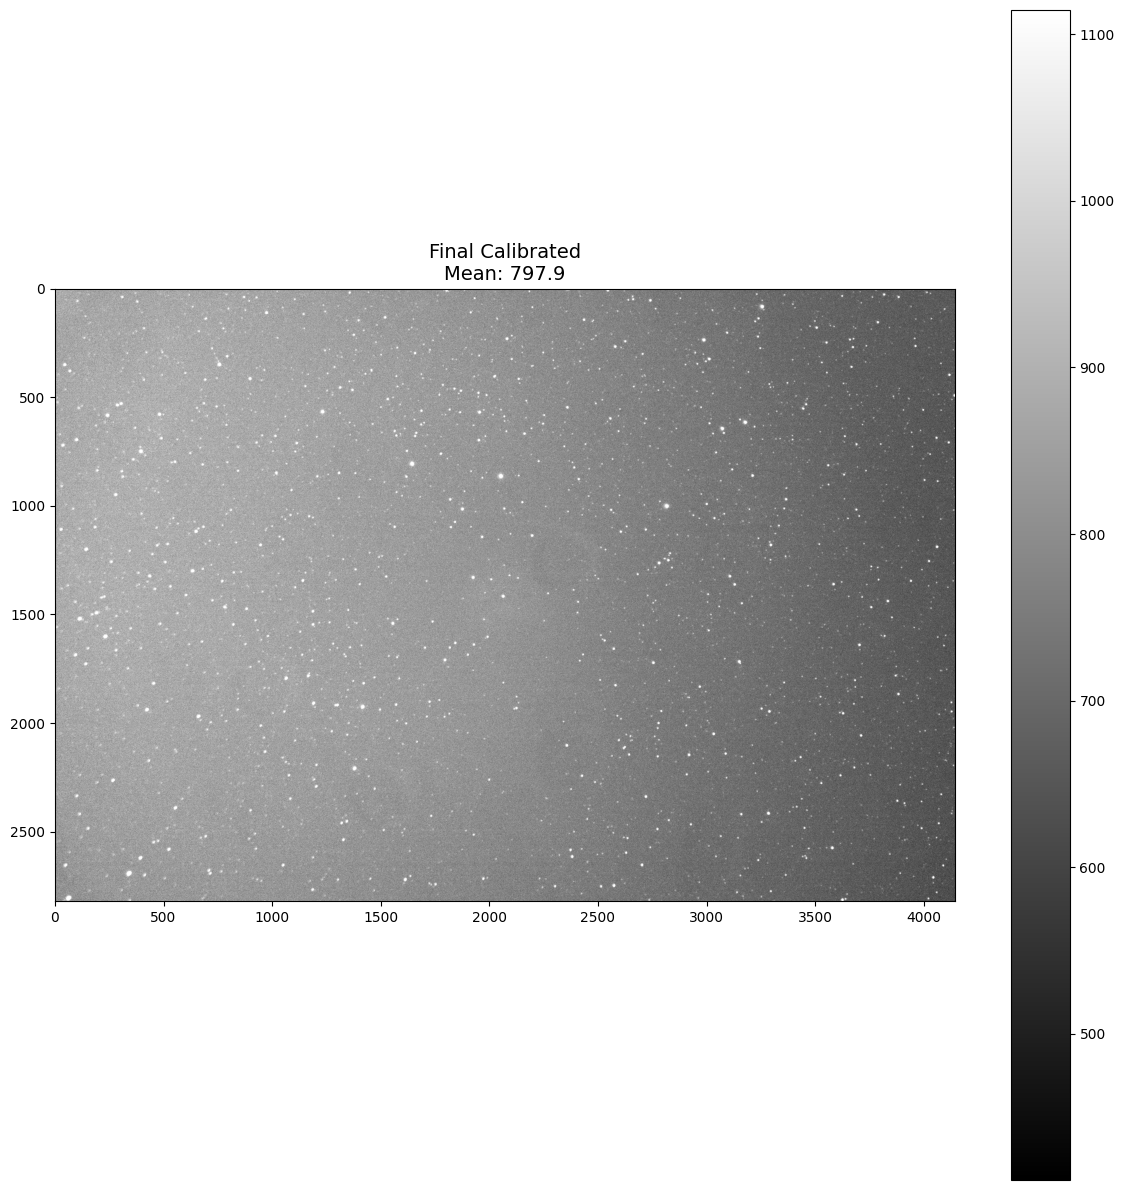

In [115]:
if dark_data is not None and flat_data is not None:
    # Create individual full-size plots for each stage
    
    # Original
    plt.figure(figsize=(12, 12))
    plt.imshow(light_data, cmap='gray', 
               vmin=np.percentile(light_data, 1), 
               vmax=np.percentile(light_data, 99))
    plt.colorbar()
    plt.title(f'Original Light Frame\n{OBJECT_NAME}\nMean: {np.mean(light_data):.1f}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # After dark subtraction
    plt.figure(figsize=(12, 12))
    plt.imshow(step1, cmap='gray',
               vmin=np.percentile(step1, 1), 
               vmax=np.percentile(step1, 99))
    plt.colorbar()
    plt.title(f'After Dark Subtraction\nMean: {np.mean(step1):.1f}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Final calibrated
    plt.figure(figsize=(12, 12))
    plt.imshow(calibrated, cmap='gray',
               vmin=np.percentile(calibrated, 1), 
               vmax=np.percentile(calibrated, 99))
    plt.colorbar()
    plt.title(f'Final Calibrated\nMean: {np.mean(calibrated):.1f}', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Cannot display comparison - calibration was not performed due to missing frames.")

## Summary

This notebook demonstrated the step-by-step calibration process:

1. **Dark Subtraction**: Removes thermal noise and bias from the light frame
2. **Flat Normalization**: Normalizes the flat field to a median of 1.0
3. **Flat Division**: Corrects for vignetting and dust shadows

The calibrated image should show:
- More uniform background
- Corrected vignetting
- Removed hot pixels and thermal noise
- Corrected dust shadows

To analyze a different object or date, modify the configuration in the first cell and re-run all cells.